# Data Cleaning Guide


## Introduction

Exploratory Data Analysis (EDA) is an approach to analyzing data sets to summarize the main characteristics and identify incongruencies in the data.
Before diving into machine learning or statistical modeling, it is crucial to understand the data you are working with.
EDA helps in understanding the patterns, detecting anomalies, checking assumptions, and determining relationships in the data.

One of the most important aspects of EDA is data cleaning.
A portion of DataEval is dedicated to being able to identify duplicates and outliers as well as data points that have missing or too many extreme values.
These techniques help ensure that you only include high quality data for your projects and avoid things like leakage between training and testing sets.


### Step-by-Step Guide

This guide will walk through how to use DataEval to perform basic data cleaning.


### Environment Requirements

You will need a python environment with the following packages installed:

- `dataeval[torch]` or `dataeval[all]`
- `torchvision`


We'll begin by installing the necessary libraries to walk through this guide.


In [1]:
try:
    import google.colab  # noqa: F401

    # specify the version of DataEval (==X.XX.X) for versions other than the latest
    %pip install -q dataeval[torch]
except Exception:
    pass

In [30]:
# You will need matplotlib for visualing our dataset and numpy to be able to handle the data.
import matplotlib.pyplot as plt
import numpy as np
import torchvision.transforms.v2 as v2
from numpy.typing import NDArray
from torch.utils.data.dataloader import DataLoader

# You are only using torchvision to load in the dataset.
# If you already have the data stored on your computer in a numpy friendly manner,
# then feel free to load it directly into numpy arrays.
from torchvision import datasets

# Load the classes from DataEval that are helpful for EDA
from dataeval.detectors.linters import Duplicates, Outliers
from dataeval.metrics.stats import channelstats, datasetstats, hashstats, labelstats

# Set the random value
rng = np.random.default_rng(213)

## Step 1: Understand the Data


### Load the Data

You are going to work with the PASCAL VOC 2011 dataset.
This dataset is a small curated dataset that was used for a computer vision competition.
The images were used for classification, object detection, and segmentation.
This dataset was chosen because it has multiple classes and images with a variety of sizes and objects.

If this data is already on your computer you can change the file location from `"./data"` to wherever the data is stored.
Just remember to also change the download value from `True` to `False`.

For the sake of ensuring that this tutorial runs quickly on most computers, you are going to analyze only the training set of the data, which is a little under 6000 images.


In [31]:
# Download the data and then load it as a torch Tensor
to_tensor = v2.ToImage()
ds = datasets.VOCDetection(
    "./data",
    year="2011",
    image_set="train",
    download=True,
    transform=to_tensor,
)

# Create a data loader for the dataset
dl = DataLoader(ds)

Using downloaded and verified file: ./data/VOCtrainval_25-May-2011.tar
Extracting ./data/VOCtrainval_25-May-2011.tar to ./data


In [32]:
# Verify the size of the loaded dataset
len(ds)

5717

Before moving on, verify that the above code cell printed out 5717 for the size of the [dataset](http://host.robots.ox.ac.uk/pascal/VOC/voc2011/dbstats.html).

This ensures that everything is working as needed for the tutorial.

### Inspect the Data

As this data was used for a computer vision competition, it will most likely have very few issues, but it is always worth it to check.
Many of the large webscraped datasets available for use do contain image issues.
Verifying in the beginning that you have a high quality dataset is always easier than finding out later that you trained a model on a dataset with erroneous images or a set of splits with leakage.

In addition to the images, you'll also need to load the labels.
However, there is no standard for metadata associated with images.
Thus, you will load the metadata associated with the first image in order to explore the metadata structure and determine exactly what is contained where in the metadata.
This way you can extract just the labels for each image.


In [33]:
# Check the label structure
ds[0][1]

{'annotation': {'folder': 'VOC2011',
  'filename': '2008_000008.jpg',
  'source': {'database': 'The VOC2008 Database',
   'annotation': 'PASCAL VOC2008',
   'image': 'flickr'},
  'size': {'width': '500', 'height': '442', 'depth': '3'},
  'segmented': '0',
  'object': [{'name': 'horse',
    'pose': 'Left',
    'truncated': '0',
    'occluded': '1',
    'bndbox': {'xmin': '53', 'ymin': '87', 'xmax': '471', 'ymax': '420'},
    'difficult': '0'},
   {'name': 'person',
    'pose': 'Unspecified',
    'truncated': '1',
    'occluded': '0',
    'bndbox': {'xmin': '158', 'ymin': '44', 'xmax': '289', 'ymax': '167'},
    'difficult': '0'}]}}

Having viewed the metadata for the first image, you now know that the metadata comes through as a nested dictionary.
What you need is the _"object"_ key of the dictionary which contains a list of objects in the image.
Inside the list are additional dictionaries, one for each object found in the image.
Inside these dictionaries, the label can be found via the _"name"_ key.

Let's run through all of the labels and create a list of lists which just contains the name of each object in each image.


In [43]:
labels = []
for data in dl:
    objects = data[1]["annotation"]["object"]
    names = []
    for each in objects:
        names.extend(each["name"])
    labels.append(names)

labels[0]

['horse', 'person']

Double check that the values output from the code above matches the object names from the original metadata you viewed above.

Now that the labels for each image are contained in a friendly list, you can run some label statistics to explore the different objects found in the images.


In [44]:
# Calculate basic label statistics from the dataset
lstats = labelstats(labels)

# Display basic counts
print(f"Class Count: {lstats.class_count}")
print(f"Label Count: {lstats.label_count}")
print("--------------------------------------")

# Display counts per class
print("     Object: Total Count - Image Count")
for cls in lstats.label_counts_per_class:
    print(f"{cls:>11}:    {lstats.label_counts_per_class[cls]:>4}\
     -    {lstats.image_counts_per_label[cls]:>4}")

Class Count: 20
Label Count: 15774
--------------------------------------
     Object: Total Count - Image Count
  aeroplane:     470     -     328
    bicycle:     410     -     281
       bird:     592     -     399
       boat:     508     -     264
     bottle:     749     -     399
        bus:     317     -     219
        car:    1191     -     621
        cat:     609     -     540
      chair:    1457     -     656
        cow:     355     -     155
diningtable:     373     -     318
        dog:     768     -     636
      horse:     377     -     238
  motorbike:     375     -     274
     person:    5019     -    2142
pottedplant:     557     -     289
      sheep:     509     -     171
       sofa:     399     -     359
      train:     327     -     275
  tvmonitor:     412     -     299


The above table shows that this dataset has a total of 20 classes.  
Of the classes, person is the class with the highest total object count followed by chair and car , while person, chair and dog are the classes with the highest number of images.  
Cow, sheep, and bus are the classes with least number of objects, while the classes with the least number of images are bus, train and cow.

This table helps point out the wide variation in

- the number of classes per image,
- the number of objects per image,
- and the number of objects of each class per image.

This highlights an important concept - class balance.  
A dataset that is imbalanced can result in a model that chooses the more prominent class more often just because it's more prominent.  
To explore this concept further, see the bias tutorial in the [What's Next](#whats-next) section at the end of this tutorial.

Now that the label set has been explored, it's important to visually inspect random images across the different classes to get an idea of the quality of the data.
When inspecting the random images, you want to get an idea of the variety of backgrounds, the range of colors, the locations of objects in images,
and how often an image is seen with a single object versus multiple objects.


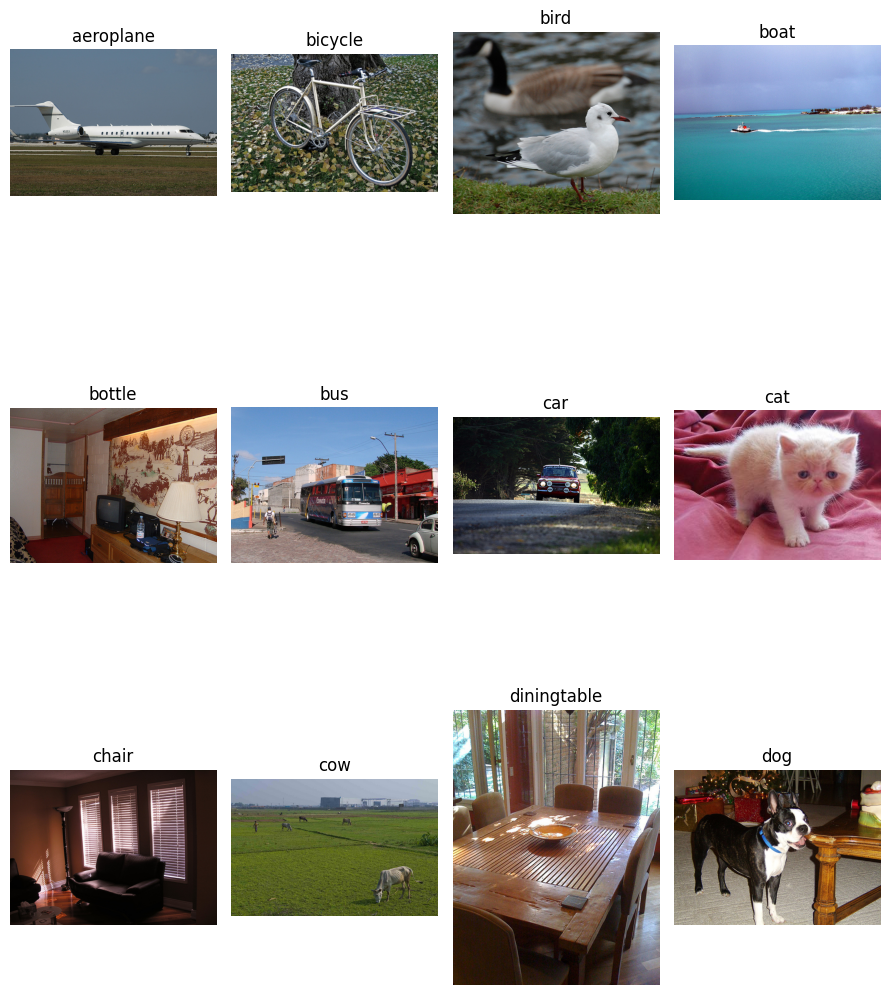

In [8]:
# Helper function to get image and permute to channels last for matplotlib
def get_image(index: int) -> NDArray:
    return np.moveaxis(ds[index][0].numpy(), 0, -1)


# Plot random images from each category
fig, axs = plt.subplots(3, 4, figsize=(9, 12))

for ax, (category, indices) in zip(axs.flat, lstats.image_indices_per_label.items()):
    # Randomly select an index from the list of indices
    selected_index = rng.choice(indices)

    ax.imshow(get_image(selected_index))
    ax.set_title(category)
    ax.axis("off")

plt.tight_layout()
plt.show()

Plotting the images displays the variety in the images, including image sizes, image brightness, object sizes, backgrounds, number of objects in the image, and even the lack of color in a few images which are black and white.

This is where DataEval comes in, it's designed to help you make sense of the many different aspects that affect building repsentative datasets and robust models.


### Summarize the Data

To begin, you are going to utilize multiple statistical analysis functions.

The `dimensionstats` `pixelstats` and `visualstats` functions each produce statistical information covering various categories of image metrics.


In [46]:
# This cell takes about 1-3 minutes to run depending on your hardware

# Calculate the dimensionstats, pixelstats and visualstats for the images
# Note: the stat functions expect the images as an iterable and in the (C,H,W) format

stats = datasetstats([d[0] for d in ds])

# Aggregate all of the results in a single dictionary
dataset_stats = stats.dict()

# View the list of metrics in the image stats class
list(dataset_stats)

 15%|█▌        | 885/5717 [00:15<01:24, 56.92it/s]


KeyboardInterrupt: 

In [27]:
test = list(d[0] for d in ds)

In [28]:
len(test)

5717

Now that the stats are computed, you should visualize the results.
To help you adequately see all of the trends in the plots, plot them once normally and once on a log scale.  
Sometimes there are only a few extreme values in a category and they can be easily overlooked if a log scale is not used.


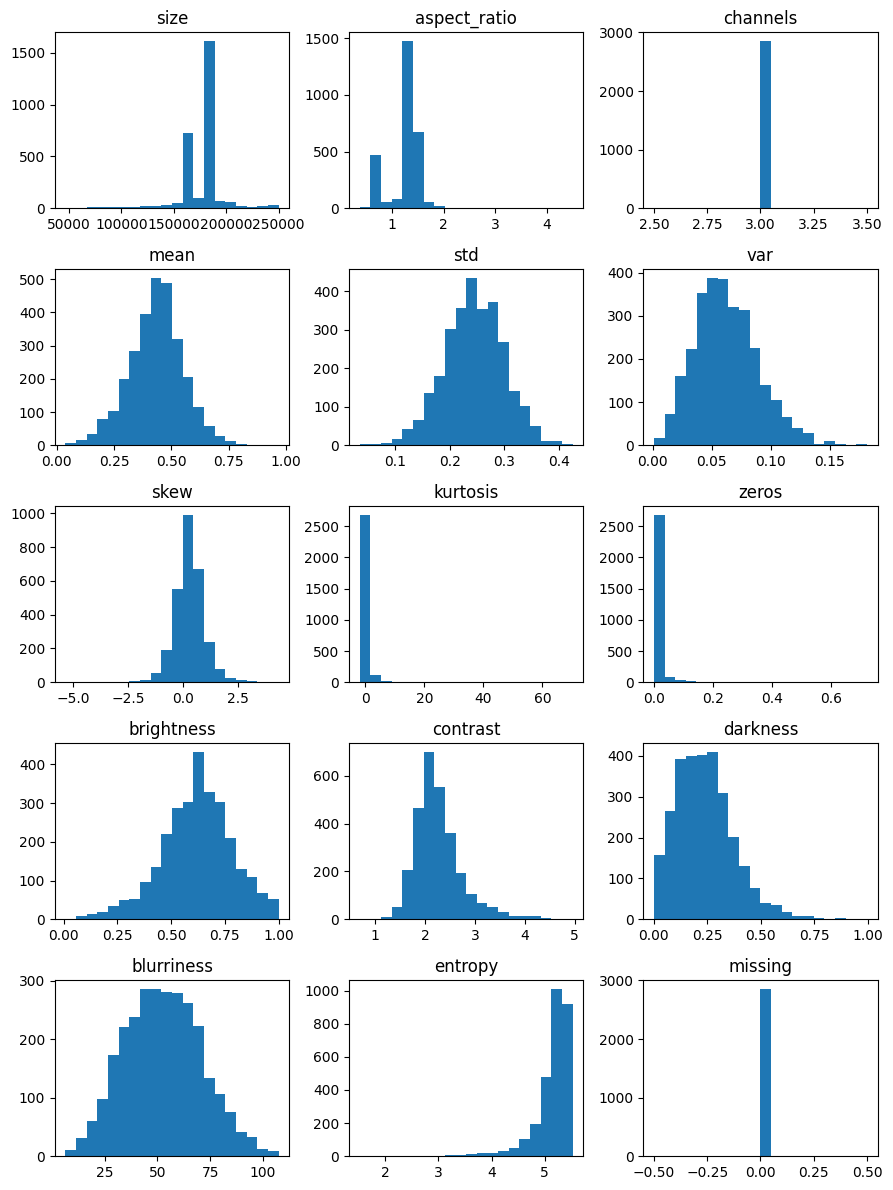

In [10]:
fig, axs = plt.subplots(5, 3, figsize=(9, 12))

for ax, metric in zip(
    axs.flat,
    [
        "size",
        "aspect_ratio",
        "channels",
        "mean",
        "std",
        "var",
        "skew",
        "kurtosis",
        "zeros",
        "brightness",
        "contrast",
        "darkness",
        "blurriness",
        "entropy",
        "missing",
    ],
):
    # Plot the histogram for the chosen metric
    ax.hist(dataset_stats[metric], bins=20)
    ax.set_title(metric)

plt.tight_layout()
plt.show()

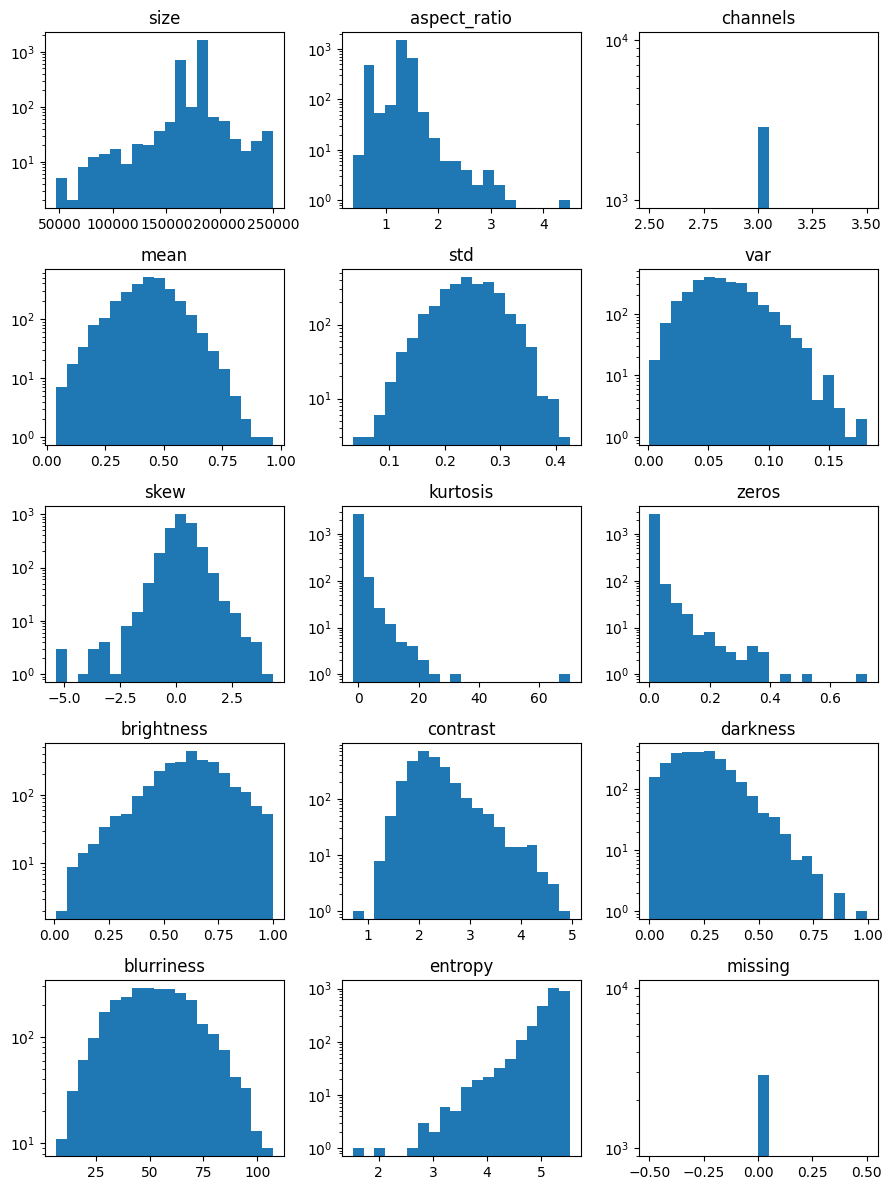

In [11]:
fig, axs = plt.subplots(5, 3, figsize=(9, 12))

for ax, metric in zip(
    axs.flat,
    [
        "size",
        "aspect_ratio",
        "channels",
        "mean",
        "std",
        "var",
        "skew",
        "kurtosis",
        "zeros",
        "brightness",
        "contrast",
        "darkness",
        "blurriness",
        "entropy",
        "missing",
    ],
):
    # Plot the histogram on a log scale for the chosen metric
    ax.hist(dataset_stats[metric], bins=20, log=True)
    ax.set_title(metric)

plt.tight_layout()
plt.show()

Plotting the distribution of values for each metric allows one to quickly inspect the metrics for unusual distributions.
Without knowing anything about the images, assume that each metric should follow one of two types of distributions: normal or uniform.

With a [uniform distribution](https://en.wikipedia.org/wiki/Discrete_uniform_distribution), you want to notice if any of the plots have areas that are a lot shorter or a lot taller than the rest of the values.

With a [normal distribution](https://en.wikipedia.org/wiki/Normal_distribution), you are looking at the edges of the bell curve to see if the values near the edges of the plot raise up or if there are gaps between the edge values and the next value in.

Looking at the plots, there are a few key things to point out:

1. The channel metric has only one value, 3. This is interesting since some of the images from our random plot above are greyscale, which usually only has 1 channel.
2. The entropy, zeros, kurtosis, and contrast metrics are single-tailed and all of them have a long tail which indicates that the images whose values are in the edges of the tail are potentially problematic.
3. Size, aspect ratio, variance, skew, brightness and darkness have skewed or off-center distributions which is another sign of problematic images.
4. Mean, standard deviation and blurriness appear to have a normal distribution and none have an extended tail, which is a good sign.

While this does not tell you which images are the problematic ones, it provides some insight into the metrics the `Outliers` class should flag.  
From these plots, you should expect the Outliers class to flag images with issues in the following metrics:

- size,
- aspect ratio,
- variance,
- skew,
- kurtosis,
- zeros,
- brightness,
- contrast,
- darkness, and
- entropy.

Before moving on to the Outliers class, you should analyze the channel stats to see if there are any additional metrics that might be problematic.


In [12]:
# This cell takes about 1-3 minutes to run depending on your hardware

# Calculate the per-channel pixelstats and visualstats for the images
# Note: the stat functions expect the images as an iterable and in the (C,H,W) format
ch_stats = channelstats(d[0] for d in ds)

# Aggregate all of the results in a single dictionary
ds_channel_stats = ch_stats.dict()

# View the list of metrics in the channel stats class
list(ds_channel_stats)

2858it [00:53, 53.09it/s]


['source_index',
 'box_count',
 'mean',
 'std',
 'var',
 'skew',
 'kurtosis',
 'histogram',
 'entropy',
 'brightness',
 'blurriness',
 'contrast',
 'darkness',
 'missing',
 'zeros',
 'percentiles']

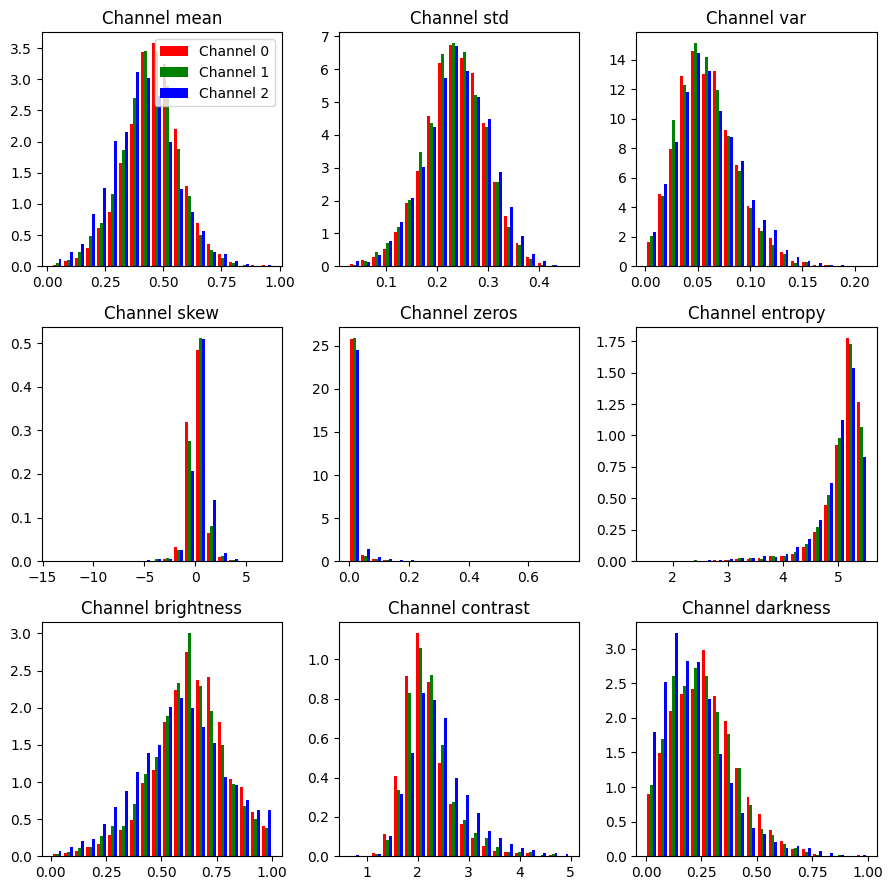

In [13]:
ch_mask = ch_stats.pixelstats.get_channel_mask(None, 3)
fig, axs = plt.subplots(3, 3, figsize=(9, 9))
label_kwarg = {"label": ["Channel 0", "Channel 1", "Channel 2"]}

for ax, metric in zip(
    axs.flat,
    [
        "mean",
        "std",
        "var",
        "skew",
        "zeros",
        "entropy",
        "brightness",
        "contrast",
        "darkness",
    ],
):
    # Plot the histogram for the chosen metric
    # Since each image has 3 channels, a reshape is needed for matplotlib
    # because matplotlib treats the # of columns as different datasets
    ax.hist(
        ds_channel_stats[metric][ch_mask].reshape(-1, 3),
        bins=20,
        density=True,
        color=["red", "green", "blue"],
        **label_kwarg,
    )
    ax.set_title(f"Channel {metric}")

    # Set label for first chart only
    if label_kwarg:
        ax.legend()
        label_kwarg = {}

plt.tight_layout()
plt.show()

With the understanding from above about uniform and normal distributions, you want to analyze the channel-based metrics with the same principle.

Here the plots show that the overall shape for each channel metrics matches the shape of their image metric counterparts.
When analyzing the channel metrics, you should not be interested in the overall shape of these plots but in the comparison of the shape across each of the individual channels.
You want to see if the same shape holds across each channel or if there are large differences between the channels.
This is important because discrepancies across channels can help detect image processing errors and channel bias.

However, their is very little difference across the channels for each metric.  
There is a slight shift in the blue channel for the mean, skew, brightness, and darkness metrics, but it is not enough of a difference to warrant suspicion.
Thus, no additional metric is added to the list of metrics expected to be flagged by the Outliers class.
The expected metrics to be flagged are:

- size,
- aspect ratio,
- variance,
- skew,
- kurtosis,
- zeros,
- brightness,
- contrast,
- darkness, and
- entropy.

Now, you can move on to identifying which images have a statistical difference from the rest of the images.


## Step 2: Identify any Outlying Data Points


### Extreme/Missing Values

Here you will detect and identify the images associated with the extreme values from the plotted metrics above.
To detect these extreme values, you will use the `Outliers` class.
The `Outliers` class has multiple methods to determine the extreme values, which are discussed in the [Data Cleaning explanation](../concepts/DataCleaning.md).
For this guide, you will use the "zscore" as the Z score defines outliers in a normal distribution.

The output of the `Outliers` class contains a dictionary where the image number is the key and the value is a dictionary containing the flagged metrics and their value.


In [14]:
# Initialize the Outliers class
outliers = Outliers(outlier_method="zscore")

# Find the extreme images
outlier_imgs = outliers.from_stats(stats)

# View the number of extreme images
print(f"Number of images with extreme values: {len(outlier_imgs)}")

Number of images with extreme values: 251


This class can flag a lot of images, depending on how varied the dataset is and which method you use to define extreme values.  
Using the zscore, it flagged 498 images across 15 metrics out of the 5717 images in the dataset.
However, switching the method can give different results.


In [15]:
# List the metrics with an extreme value
metrics = {}
for img, group in outlier_imgs.issues.items():
    for extreme in group:
        if extreme in metrics:
            metrics[extreme].append(img)
        else:
            metrics[extreme] = [img]
print(f"Number of metrics with extremes: {len(metrics)}")

# Show the total number of extreme values for each metric
for group, imgs in sorted(metrics.items(), key=lambda item: len(item[1]), reverse=True):
    print(f"  {group} - {len(imgs)}")

Number of metrics with extremes: 15
  size - 91
  entropy - 67
  zeros - 51
  contrast - 50
  skew - 45
  kurtosis - 35
  darkness - 26
  width - 21
  aspect_ratio - 20
  var - 17
  mean - 15
  brightness - 14
  height - 13
  std - 11
  blurriness - 1


Digging into the flagged images and organizing them by category shows that the metric with the most extreme values is "size" while "blurriness" has the least number of extreme values.
It is also worth noting that the result from `Outliers` found issues with more metrics than was anticipated.
Going back to the expected list, there was

- size,
- aspect ratio,
- variance,
- skew,
- kurtosis,
- zeros,
- brightness,
- contrast,
- darkness, and
- entropy.

However, the result from `Outliers` added mean, standard deviation, and blurriness (because size was an expected issue, width and height are counted as expected).
The result from `Outliers` is not perfect but it is designed to flag any image that might be problematic.
It is then up to you, the user, to shift through the information provided by the result from `Outliers`.

Part of exploring the results includes displaying how the flagged images are spread across the 20 classes.


In [16]:
# Show each metric by class
# Determine which classes are present in each image
class_wise = {obj: {} for obj in sorted(lstats.image_indices_per_label)}
for group, imgs in metrics.items():
    for img in imgs:
        unique_items = set(labels[img])
        for cat in unique_items:
            if group not in class_wise[cat]:
                class_wise[cat][group] = 0
            class_wise[cat][group] += 1

# Create the table for displaying
table_header = ["      Class"]
for group in sorted(metrics.keys()):
    table_header.append(f"{group:^10}")
table_header.append("  Total")
table = [table_header]
for class_cat, results in class_wise.items():
    table_rows = [f"{class_cat:>11}"]
    total = 0
    for group in sorted(metrics.keys()):
        if group == "aspect_ratio":
            if group in results:
                table_rows.append(f"{results[group]:^12}")
                total += results[group]
            else:
                table_rows.append(f"{0:^12}")
        else:
            if group in results:
                table_rows.append(f"{results[group]:^10}")
                total += results[group]
            else:
                table_rows.append(f"{0:^10}")
    table_rows.append(f"  {total:^5}")
    table.append(table_rows)

(linting-issues-by-metric-table)=

#### Linting Issues by Metric Table


In [17]:
# Display the table
for row in table:
    print(" | ".join(row))

      Class | aspect_ratio | blurriness | brightness |  contrast  |  darkness  |  entropy   |   height   |  kurtosis  |    mean    |    size    |    skew    |    std     |    var     |   width    |   zeros    |   Total
  aeroplane |      0       |     0      |     0      |     0      |     2      |     1      |     0      |     1      |     0      |     3      |     2      |     0      |     2      |     2      |     2      |    15  
    bicycle |      0       |     0      |     0      |     2      |     2      |     3      |     0      |     2      |     0      |     3      |     2      |     0      |     1      |     0      |     5      |    20  
       bird |      2       |     0      |     1      |     7      |     2      |     5      |     0      |     4      |     1      |     12     |     7      |     0      |     0      |     3      |     6      |    50  
       boat |      1       |     0      |     0      |     3      |     1      |     7      |     1      |     2      |     

Some of the things to note from splitting up the issues by class and metric:

- An image with an unusual aspect ratio is most likely to contain a boat or aeroplane
- An image with an issue in brightness is most likely to contain a person
- An image with an issue in darkness is most likely to be an aeroplane
- Images with high contrast are likely to fall within 1 of 4 classes: bottle, cat, chair, person
- Images with low entropy (think image with constant pixels) are likely to fall within 1 of 4 classes: aeroplane, bird, bottle, person
- Unusual skew and kurtosis images follow a similar trend as entropy
- Every class has images with size issues

There appear to be other trends as well.  
Something to remember is that there are different number of images for each class.
For example, 36 low entropy images out of the 2000 for person might be outliers while 28 low entropy images out of 300 for aeroplane might not be;
low entropy might be an inherent characteristic of class aeroplane.


In order to understand the above table, you will plot sample images from a few of the metrics, specifically:

- entropy,
- size,
- zeros, and
- blurriness.

Entropy because Entropy, Variance, Standard deviation, Kurtosis, and Skew all measure (in slightly different ways) how much change there is across the pixels in the image, and entropy will be the easiest to understand.

Size because Size, Width, Height and Aspect Ratio are all interrelated and size has the most extreme images from those.

Zeros is a category unto itself but it is closely related to Brightness, Contrast, Darkness, and Mean. Zeros measures images that have a significant number of pixels with a zero value compared to the average image.

Blurriness because it is also in it's own category. Blurriness measures the sharpness of lines in an image.


(questions)=

#### Questions

When looking at these images, you want to think about the following questions:

- Does this image represent something that would be expected in operation?
- Is there commonality to the objects in the images? Such as all the objects are found on the leftside of the images.
- Is there commonality to the backgrounds of the images? Such as similar colors, darkness/brightness, places, things (like water or snow).
- Is there commonality to the class of objects in the images? Such as a specific pose for person or specific pot color for pottedplant.


In [18]:
# Helper method to plot images of interest
def plot_sample_images(metric: str, layout: tuple[int, int]) -> None:
    _, axs = plt.subplots(*layout, figsize=(12, 9))
    selected_index = rng.choice(metrics[metric], min(np.prod(layout), len(metrics[metric])), replace=False)

    for i, ax in enumerate(axs.flat):
        ax.imshow(get_image(selected_index[i]))
        ax.set_title(dataset_stats[metric][selected_index[i]])
        ax.axis("off")

    print(f"metric={metric}")
    print(f"quantiles={np.round(np.quantile(dataset_stats[metric], [0, 0.25, 0.5, 0.75, 1]), 2)}")
    plt.tight_layout()
    plt.show()

#### Entropy


metric=entropy
quantiles=[1.52 5.06 5.23 5.36 5.53]


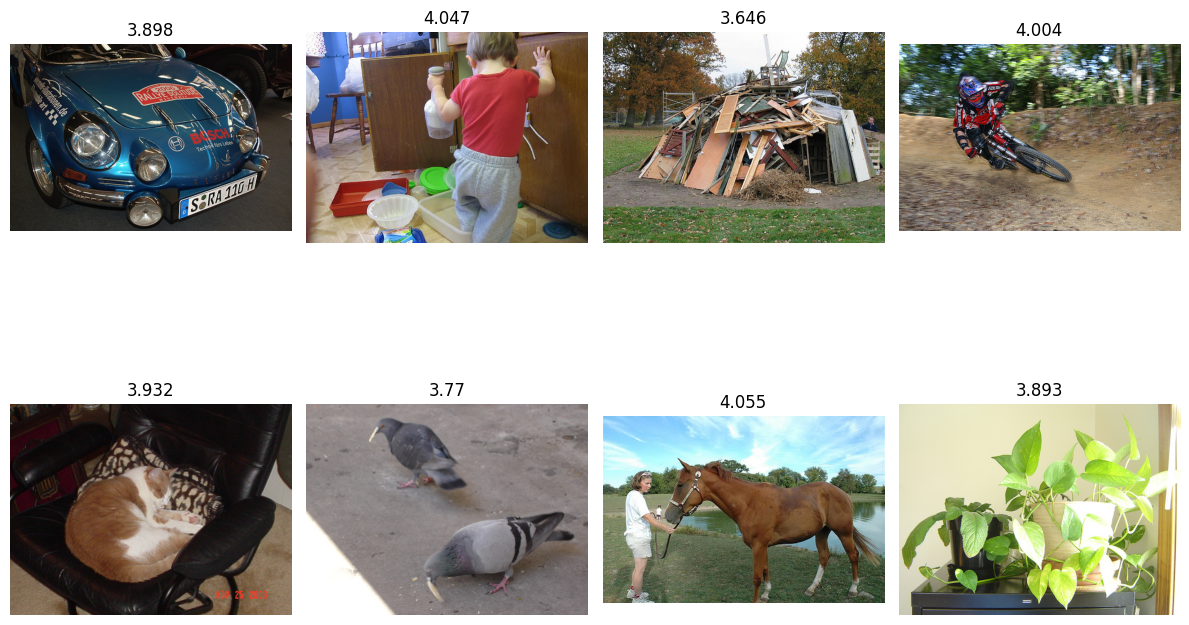

In [19]:
# Plot images flagged for "entropy"
plot_sample_images("entropy", (2, 4))

Looking at the flagged images for entropy, what do you see?

Many of the flagged images here have an almost constant background.
Thinking back to our questions - how many of these backgrounds will you see in operation? Are you likely to find water in your images or an object in the sky?  
It is also worth pointing out the number of images that have a relatively dark background. How likely are you to encounter night time or dark images in your operation?  
If water or objects in the sky or dark backgrounds are expected, then you may just need to collect more images with these kinds of backgrounds. If not, then they are outliers that can be discarded.  
To learn more about data collection, go [here](https://viso.ai/computer-vision/data-collection/).


#### Size


metric=size
quantiles=[ 46656. 166500. 187500. 187500. 250000.]


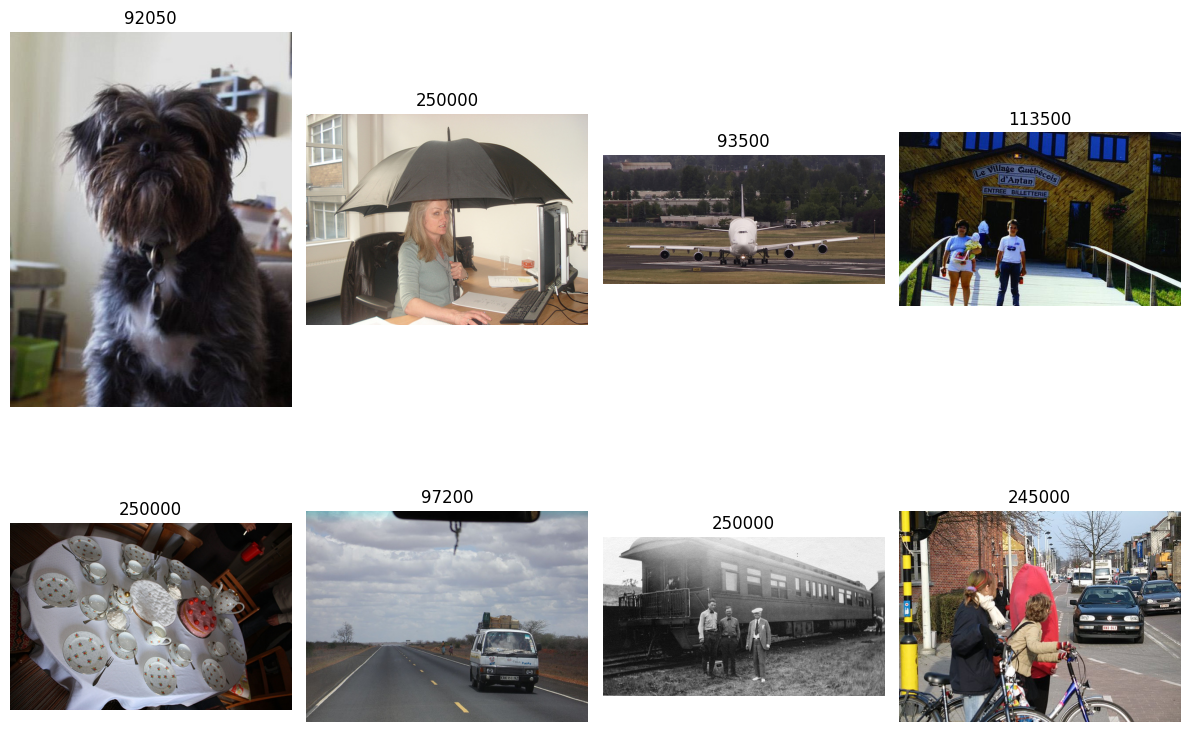

In [20]:
# Plot images flagged for "size"
plot_sample_images("size", (2, 4))

If this was a real workflow where you were going to train a model on these images,
you would need to decide whether your model workflow will preprocess images to be the exact same size or if you only wanted to only include images of a specific size.  
If preprocessing the images, you will want to make sure that your method does not cause distortions to the image (such as resizing)
and that you still have the desired information in the image (such as when cropping).
If you are expecting an image of a specific size, then you can easily just discard the incorrectly sized images.
However, you would then need to make sure that this does not introduce any bias into your dataset.

Now that you've thought about your workflow, let's look at the flagged images for size.

The first thing of note is that there are a lot of images here with animals.
Here you want to think about how images of animals are taken and is this discrepancy in size a natural artifact of animal pictures or just a by product of the data collection methods?
Recalling from the [table](#linting-issues-by-metric-table) above, issues with size are pretty spread out across all classes, so dropping all of them might be okay, but you will definitely want to check for bias after dropping them.


#### Zeros


metric=zeros
quantiles=[0.   0.   0.   0.01 0.72]


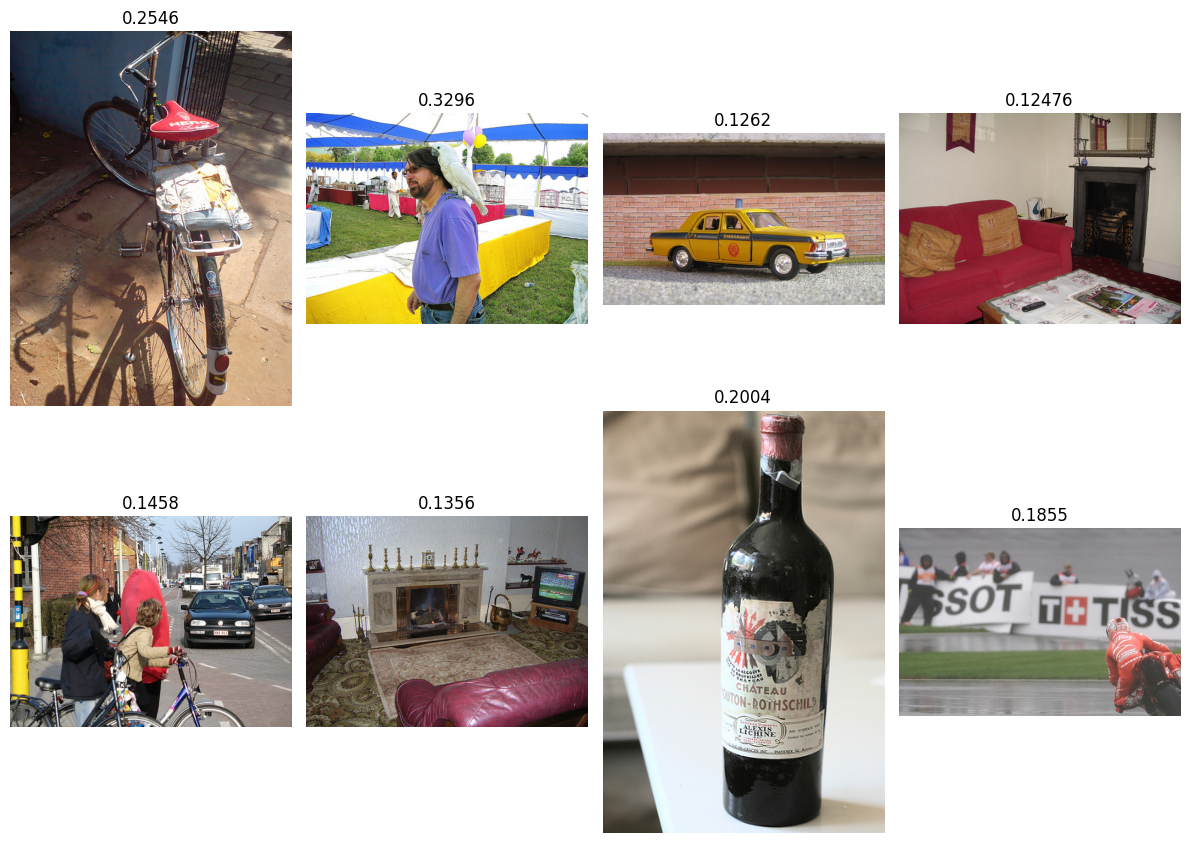

In [21]:
# Plot images flagged for "zeros"
plot_sample_images("zeros", (2, 4))

Looking at the flagged images for zeros, what do you see?

Similarly to entropy, which was addressed above, some of these images have a dark background. Is this expected for this dataset?  
Also, of note is the grayscale images. Here, you want to think about how often will the model come across greyscale images in operation, and can a malfunction in the pipeline (either hardware or software) produce greyscale images and if so how likely will that kind of malfunction occur?

For both of those cases, dark backgrounds and greyscale images, do they occur proportionately throughout all of the classes or do they exist in only 1 or 2 classes?
If they occur in only 1 or 2 classes, then you might just want to throw them out so that your model doesn't just learn to associate dark backgrounds or greyscale with those classes.


#### Blurriness


IndexError: index 1 is out of bounds for axis 0 with size 1

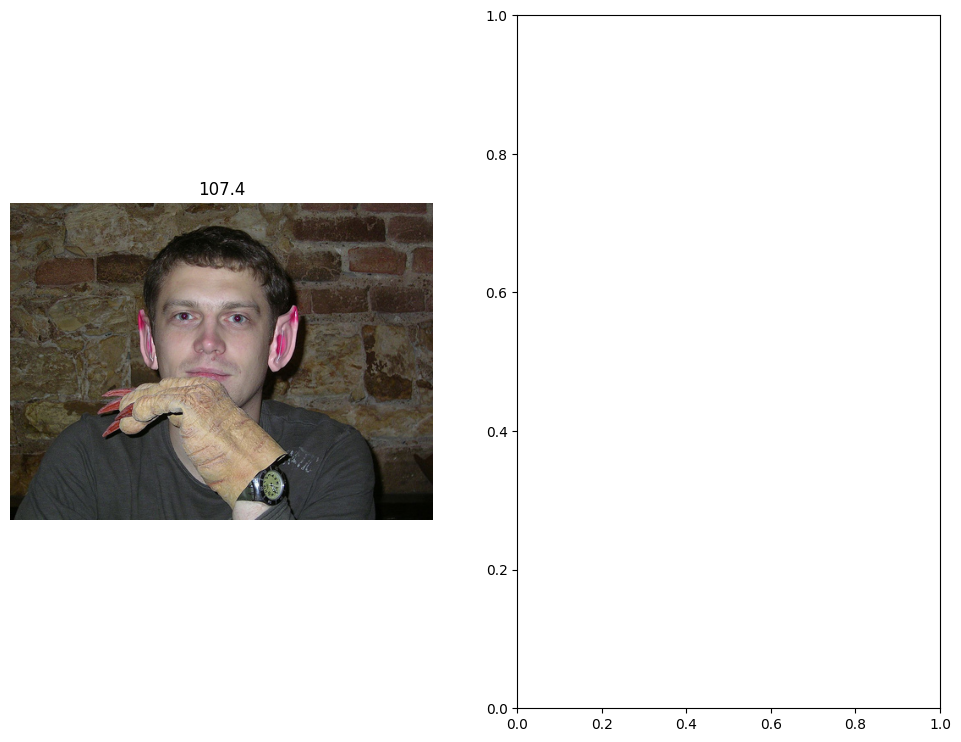

In [22]:
# Plot images flagged for "blurriness"
plot_sample_images("blurriness", (1, 2))

Looking at the flagged images for blurriness, what do you see?

That neither of these images appear to be blurry.
These images may actually have a higher resolution than the rest of the images, thus they are significantly less blurry than average.  
Also of note, is the background to the images, the grass and the leaves. Are those common backgrounds or are these the only images with a close up with leaves and grasses in the background?
Is this operationally relevant? If not, then these two images should just be removed. If yes, then additional images are needed with these two backgrounds.


#### Linting Summary

The `Outliers` class can not tell you what is operationally relevant, but it does inform about which images stand out from the rest in one way or another.

After viewing these images that stand out, there are two key takeaways to keep in mind:

1. Many of the flagged images will be flagged by more than one metric.
2. Plotting the flagged metrics allows you to get an idea of what the `Outliers` class calls an outlier.
   Not all of these images are outliers, some of them could represent areas in our dataset that are underrepresented.

DataEval is used to identify images which _may be_ problematic in your dataset, but it cannot specify whether an image is actually an outlier or not.  
Applying the four [questions](#questions) above to each image that stands out, will help you in determining whether the image should be removed or not from the dataset.


## Step 3: Identify duplicate data


### Duplicates

Now that you know how to identify poor quality images in your dataset, another important aspect of data cleaning is detecting and removing any duplicates.

The `Duplicates` class identifies both exact duplicates and potential (near) duplicates.
Potential duplicates can occur in a variety of ways:

- Intentional permutations
  - Images with varying brightness
  - Translating the image
  - Padding the image
  - Cropping the image
- Unintentional changes
  - Copying the image from one format to another (png->jpeg)
  - Including a permuted image and the original


In [ ]:
# Initialize the Duplicates class
dups = Duplicates()

# Find the duplicates
dups.evaluate(d[0] for d in ds)

As expected there are no duplicates in this dataset, since it was curated for a specific competition.

However, to highlight the abilities of the `Duplicates` class, you will add some duplicates to the dataset and then rerun the `Duplicates` class.


In [ ]:
# Create exact and duplicate images

# Copy images 23 and 46 to create exact duplicates
# Copy and crop images 5 and 4376 to create near duplicates
dupes = [
    ds[23][0],
    ds[46][0],
    ds[5][0][:, 5:-5, 5:-5],
    ds[4376][0][:, :-5, 5:],
]

dupes_stats = hashstats(dupes)

In [ ]:
# Find the duplicates appended to the dataset
duplicates = dups.from_stats([dups.stats, dupes_stats])
print(f"exact: {duplicates.exact}")
print(f"near: {duplicates.near}")

As shown above, the Duplicates class identified all images from the second dataset as exact or near duplicates.

Images 0 and 1 from dataset 1 are identified as exact duplicates of images 23 and 46, respectively from the original dataset (dataset 0). Images 2 and 3 from dataset 1 are identified as near duplicates of images 5 and 4376, respectively, which were cropped from the original dataset (dataset 0).


## Conclusion


Now comes the fun part, determining what data points are supposed to be in the data set, what points need to be removed, and whether or not you need to collect more data points for a given class or style of image.

You will need to inspect the flagged images.
Viewing the flagged images in relation to the other images with the same class and the rest of the dataset, will help you determine what to do with the image.
Examples of issues include mislabeled images, classes with under-represented samples, and discrepancies in image characteristics (e.g. brightness) between classes.

As you can see, the DataEval methods are here to help you gain a deep understanding of your dataset and all of it's strengths and limitations.
It is designed to help you create representative and reliable datasets.

Good luck with your data!

---


## What's Next

In addition to exploring a dataset in it's feature space, DataEval also offers the following tutorials:

- Explore images through clustering with the [Assessing the Data Space Guide](EDA_Part2.ipynb)
- Identify bias or other factors in a dataset which may influence model performance with the [Identifying Bias and Correlations Guide](EDA_Part3.ipynb)
- Monitor data for shifts during operation with the [Data Monitoring Guide](Data_Monitoring.ipynb)

To learn more about specific functions or classes, see the [Concept pages](../concepts/index.md).


## On your own

Now that you've gone through a tutorial on exploring a dataset, try going through the tutorial again with the test set, full dataset, or even your own dataset.
One thing to look for when checking other sets of data is to observe how the stats of each grouping of data changes or doesn't change.

You can also play around with the different statistical methods that the Outlier class employs to see how the method affects the number and type of issues detected.